# Local Gaussian Processes

The purpose of this notebook is to look at the first way of speeding up the training of a Gaussian Process, through separating the data into multiple independent GPs. Because the training of a GP is $O(n^3)$, the overall training process can be sped up by separating the training data into two (or more).  This reduces the the training time by $2 \cdot O((\frac{n}{2})^3) = O(\frac{n}{4})$ because of the cubic nature of the training time.  More generally, the fraction of training time it will take is $\frac{1}{clusters^2}$ where clusters is the number of groups the GP is broken into.

This notebook is broken down into five parts in order to effectively use this methodology.
1. Use k-means clustering to break data into different input sets
2. Have each set train an independent GP
3. Make a prediction using the combined GP structure
4. State Predictions
5. Validation

In [1]:
# Import Relevant Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Load in data
df = pd.read_csv('data/dataset1.csv')

## Part 1: K-Means Clustering

The first part of speeding up the overall training is by separating the dataset into clusters.  For this example, 3 clusters were chosen, though the specific number is dependent on your specific use case and accuracy and speed requirements.  Note that with this methodology, each GP can be though of as covering a separate region of the input space.

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

num_of_clusters = 3

df_training = df.copy()
df_training = df_training.iloc[0:2000]

# Apply k-means clustering using only x1 and x2
X = df_training[['u', 'h1', 'h2']]
kmeans = KMeans(n_clusters=num_of_clusters, random_state=42)
df_training['cluster'] = kmeans.fit_predict(X)

# Get cluster centroids
centroids = kmeans.cluster_centers_

# Separate data into clustered dataframes
clusters = [df_training[df_training['cluster'] == i] for i in range(num_of_clusters)]

# Part 2: Train the GPs

Since we have the data split into two different groups, training the GPs isn't particularly hard.  Using the enumerate function, we are able to take the data that was assigned to each cluster and use only that to train our GPs.  For this, we will be using a Matern Kernel for the same reasons as in the base case.

In [3]:
# Function to create and train a Gaussian Process model
def train_gp(X, y):
    kernel = Matern(nu = 0.5)
    gp = GaussianProcessRegressor(kernel=kernel, 
                                  n_restarts_optimizer=10, 
                                  random_state=42)
    gp.fit(X.values, y.values)
    return gp

# Setup to Train Gaussian Process models for each cluster
gp_models_dh1 = []
mse_scores_dh1 = []

# Train the GP clusters for dh1
for i, cluster in enumerate(clusters):
    print(f"\nTraining Gaussian Process for Cluster {i+1}")
    
    X = cluster[['u', 'h1', 'h2']]
    y = cluster['h1_der']
        
    gp = train_gp(X, y)
    gp_models_dh1.append(gp)

# Setup to Train Gaussian Process models for each cluster
gp_models_dh2 = []
mse_scores_dh2 = []

# Train the GP clusters for dh2
for i, cluster in enumerate(clusters):
    print(f"\nTraining Gaussian Process for Cluster {i+1}")
    
    X = cluster[['u', 'h1', 'h2']]
    y = cluster['h2_der']
        
    gp = train_gp(X, y)
    gp_models_dh2.append(gp)


Training Gaussian Process for Cluster 1

Training Gaussian Process for Cluster 2


c:\Users\micha\anaconda3\envs\online_update_controls\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)



Training Gaussian Process for Cluster 3

Training Gaussian Process for Cluster 1


c:\Users\micha\anaconda3\envs\online_update_controls\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



Training Gaussian Process for Cluster 2


c:\Users\micha\anaconda3\envs\online_update_controls\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)



Training Gaussian Process for Cluster 3


## Part 3: Making Derivative Predictions

For the last part of this methodology, we need to combine the GPs to make a singular prediction.  For this, we will implement two methods: 1) a weighted sum based on the inverse of the Euclidean distance of a particular point to the centroids of each GP's training data and 2) using only the GP whose centroid is closest to the inputs given.  We can then make the calculations and see how accurate the predictions are.

In [4]:
# Function to calculate weights based on distance to centroids
def calculate_weights(point, centroids):
    distances = np.linalg.norm(centroids - point, axis=1)**10 # Power of 10 is hyperparameter chosen based on how quickly you want to move from one GP to the next
    weights = 1 / (distances + 1e-8)  # Add small epsilon to avoid division by zero
    return weights / np.sum(weights)

# Function to make a weighted prediction
def weighted_predict(point, gp_models, centroids):
    weights = calculate_weights(point, centroids)
    predictions = np.array([gp.predict([point])[0] for gp in gp_models])
    weighted_pred = np.sum(weights * predictions)
    return weighted_pred

# Function to find the closest centroid
def closest_centroid(point, centroids):
    distances = np.linalg.norm(centroids - point, axis=1)
    closest_index = np.argmin(distances)
    return closest_index

# Function to make a prediction using the closest GP model
def closest_predict(point, gp_models, centroids):
    closest_index = closest_centroid(point, centroids)
    closest_gp = gp_models[closest_index]
    prediction = closest_gp.predict([point])[0]
    return prediction

df['h1_der_predictions'] = df.apply(lambda row: closest_predict([row['u'], row['h1'], row['h2']], gp_models_dh1, centroids), axis = 1)
df['h2_der_predictions'] = df.apply(lambda row: closest_predict([row['u'], row['h1'], row['h2']], gp_models_dh2, centroids), axis = 1)

## Part 4: State Predictions

We can now continue as normal, making state predictions to assess the model.

In [5]:
# Create vector of times and pump signals
tvec = df["time"].values
u = df['u'].values
# Create blank vectors for h1 and h2 values
h1 = np.zeros_like(tvec, dtype=float)
h2 = np.zeros_like(tvec, dtype=float)

# Initial Conditions
h1[0] = df["h1"].values[0]
h2[0] = df["h2"].values[0]
# Integration using forward Euler
for i in range(len(tvec) - 1):
    h1[i + 1] = h1[i] + 5 * closest_predict([u[i], h1[i], h2[i]], gp_models_dh1, centroids)
    h2[i + 1] = h2[i] + 5 * closest_predict([u[i], h1[i], h2[i]], gp_models_dh2, centroids)

df['h1_prediction'] = h1
df['h2_prediction'] = h2

## Part 5: Validation

Validation is done on the last 20% of data as before.

In [6]:
MSE = np.sum((df['h2'][2000:-1] - df['h2_prediction'][2000:-1])**2)/len(df)
print('The MSE for the Local GP Case is:', round(MSE,4))

The MSE for the Local GP Case is: 0.0094


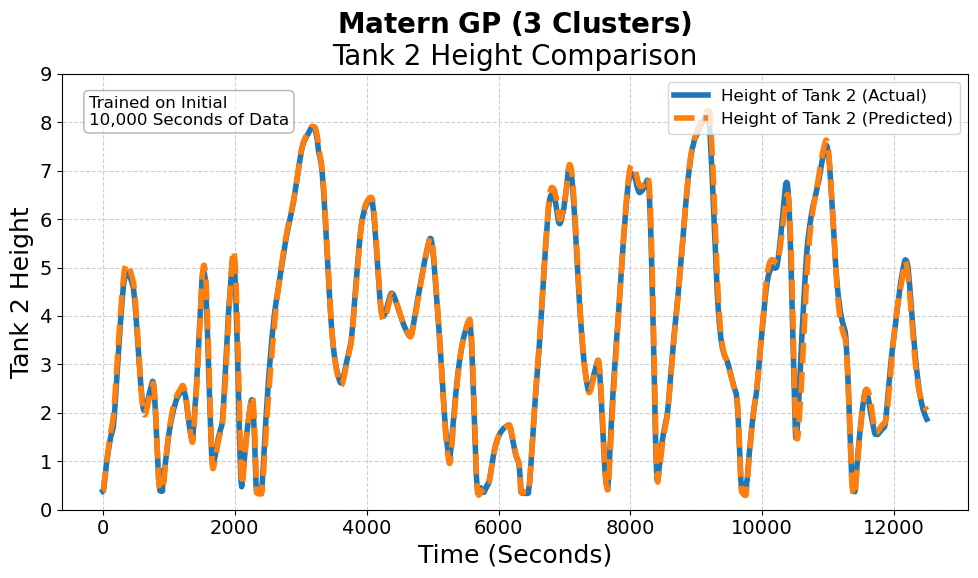

In [7]:
# Plot with improved aesthetics
plt.rcParams.update({'font.size': 14})  # Adjust the number to increase/decrease font size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both the actual and predicted data
ax.plot(df['time'], df['h2'], label='h2', linewidth=4, linestyle='-')#, color='blue')
ax.plot(df['time'], df['h2_prediction'], label='h2_prediction', linewidth=4, linestyle='--')#, color='red')

# Enhancing the graph with titles, labels, and grid
ax.set_title(r'$\bf{Matern\ GP\ (3\ Clusters) }$' + '\nTank 2 Height Comparison', fontsize=20)
# ax.set_title('3 Clusters Matern GP Tank 1 Height Comparison', fontsize=20)
ax.set_xlabel('Time (Seconds)', fontsize=18)
ax.set_ylabel('Tank 2 Height', fontsize=18)
ax.legend(['Height of Tank 2 (Actual)', 'Height of Tank 2 (Predicted)'], fontsize=12, loc='upper right')

ax.grid(True, linestyle='--', alpha=0.6)

# ax.text(-250, 7, 'Trained on Initial \n10,000 Seconds of Data', fontsize=12, color='black', bbox = dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4', alpha = 0.6))

# Add a note in the upper-left corner with a rounded box
ax.text(0.03, 0.95, 'Trained on Initial \n10,000 Seconds of Data',
        fontsize=12, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3', alpha = 0.6),
        transform=ax.transAxes,  # Use normalized coordinates
        verticalalignment='top',  # Align text to the top of the box
        horizontalalignment='left')  # Align text to the left

ax.set_ylim(0, 9)

# Show plot
plt.tight_layout()
plt.show()